### Anomaly detection in time series

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

First, we need to format our data in order to label each value as either an outlier or an inlier.

In [4]:
df = pd.read_csv('/content/data.csv')
df.head()

,timestamp,value
0,2014-02-14 14:30:00,0.132
1,2014-02-14 14:35:00,0.134
2,2014-02-14 14:40:00,0.134
3,2014-02-14 14:45:00,0.134
4,2014-02-14 14:50:00,0.134


The labels are listed in the NAB repository for each dataset

In [5]:
anomalies_timestamp = [
        "2014-02-26 22:05:00",
        "2014-02-27 17:15:00"
    ]

Ensure the timestamp column is an actual timestamp

In [6]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.head()

,timestamp,value
0,2014-02-14 14:30:00,0.132
1,2014-02-14 14:35:00,0.134
2,2014-02-14 14:40:00,0.134
3,2014-02-14 14:45:00,0.134
4,2014-02-14 14:50:00,0.134


Now, an outlier gets a label of -1, and an inlier gets a label of 1. This matches the output of anomaly detection algorithms in scikit-learn.

In [7]:
df['is_anomaly'] = 1

for each in anomalies_timestamp:
    df.loc[df['timestamp'] == each, 'is_anomaly'] = -1

df.head()

,timestamp,value,is_anomaly
0,2014-02-14 14:30:00,0.132,1
1,2014-02-14 14:35:00,0.134,1
2,2014-02-14 14:40:00,0.134,1
3,2014-02-14 14:45:00,0.134,1
4,2014-02-14 14:50:00,0.134,1


At this point, we have a dataset with the right timestamp format, the value, and a label to indicated whether the value is an outlier (-1) or an inlier (1).

Now, let’s plot the data to visualize the anomalies.

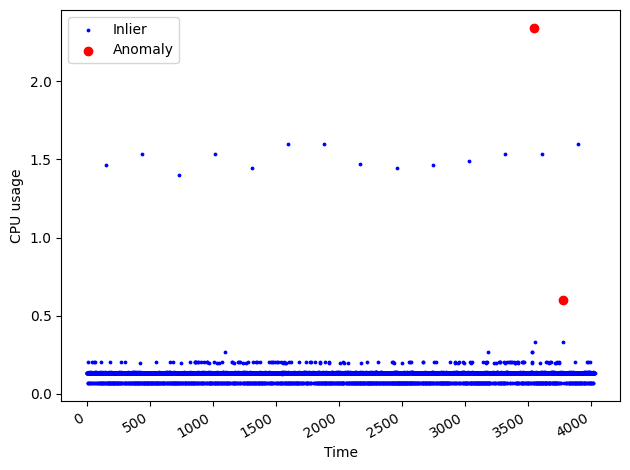

In [8]:
anomaly_df = df.loc[df['is_anomaly'] == -1]
inlier_df = df.loc[df['is_anomaly'] == 1]

fig, ax = plt.subplots()

ax.scatter(inlier_df.index, inlier_df['value'], color='blue', s=3, label='Inlier')
ax.scatter(anomaly_df.index, anomaly_df['value'], color='red', label='Anomaly')
ax.set_xlabel('Time')
ax.set_ylabel('CPU usage')
ax.legend(loc=2)

plt.grid(False)
fig.autofmt_xdate()
plt.tight_layout()

From the figure above, we can see that our data only contains two outliers, as indicated by the red dots.

This shows how challenging anomaly detection can be! Because they are rare events, we have few occasions to learn from them. In this case, only 2 points are outliers, which represent 0.05% of the data. It also makes the evaluation of the models more challenging. A method basically has two occasions of getting it right, and 4030 occasions of being wrong.

With all that in mind, let’s apply some techniques for anomaly detection in time series, starting with the mean absolute deviation.

### Median absolute deviation (MAD)

If our data is normally distributed, we can reasonably say that data points at each end of the tails can be considered an outlier.

To identify them, we can use the Z-score, which is a measurement in terms of standard deviations from the mean. If the Z-score is 0, the value is equal to the mean. Typically, we set a Z-score threshold of 3 or 3.5 to indicate if a value is an outlier or not.

Basically, if the Z-score is large, it means that the value is far from the mean and towards one end of the distribution’s tail, which in turn can mean that it is an outlier.

In [9]:
plt.rcParams["figure.figsize"] = (9,6)

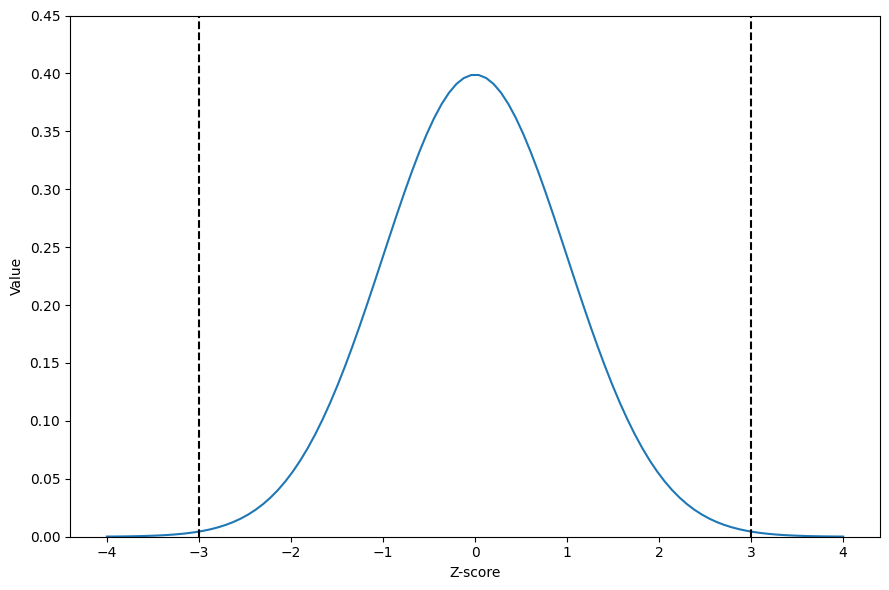

In [10]:
import scipy.stats as stats
import math

mu = 0
variance = 1

sigma = math.sqrt(variance)

x = np.linspace(mu-4*sigma, mu+4*sigma, 100)

fig, ax = plt.subplots()

ax.plot(x, stats.norm.pdf(x, mu, sigma))

ax.axvline(mu-3*sigma, 0, 1, ls='--', c='black')
ax.axvline(mu+3*sigma, 0, 1, ls='--', c='black')
ax.set_ylim(0, 0.45)
ax.set_ylabel('Value')
ax.set_xlabel('Z-score')

plt.grid(False)
plt.tight_layout()

From the figure above, we can visualize the classical Z-score threshold of 3 to determine if a value is an outlier or not. As shown by the black dashed lines, a Z-score of 3 brings us to the ends of the normal distribution. So, any value with a Z-score greater than 3 (or less than -3 if we are not working in absolute values) can be labelled as an outlier.

Now, this works great under the assumption that we have a perfectly normal distribution, but the presence of outliers necessarily affects the mean, which in turns affect the Z-score. Therefore, we turn our attention to the median absolute deviation or MAD.

### The robust Z-score method
To avoid the influence of outliers on the Z-score, instead use the median, which is a more robust metric in the presence of outliers.

The median absolute deviation or MAD is defined as:

**MAD = median(|Xi - X^|)**


Basically, the MAD is the median of the absolute difference between the values of a sample and the median of the sample. Then, we can calculate the robust Z-score with:

**Mi = 0.97459(Xi - X^) / MAD**

Here, the robust Z-score takes the difference between a value and the median of the sample, multiplies it by 0.6745 and we divide everything by the MAD. Note that 0.6745 represents the 75th percentile of a standard normal distribution.

***Why 0.6745?***

Unlike the traditional Z-score, the robust Z-score uses the median absolute deviation, which is always smaller than the standard deviation. Thus, to obtain a value that resembles a Z-score, we must scale it.

In a normal distribution with no outliers, the MAD is about 2/3 (0.6745 to be precise) as big as the standard deviation. Therefore, because we are dividing by the MAD, we multiply by 0.6745 to get back to the scale of the normal Z-score.



**The robust Z-score method will work best under two important assumptions:**

1. The data is close to a normal distribution
2. The MAD is not equal to 0 (happens when more than 50% of the data has the same value)


The second point is interesting, because if that is the case, then any value that is not equal to the median will be flagged as an outlier, no matter the threshold, since the robust Z-score will be incredibly large.




**Applying the MAD for outlier detection**

First, we need to check the distribution of our data.

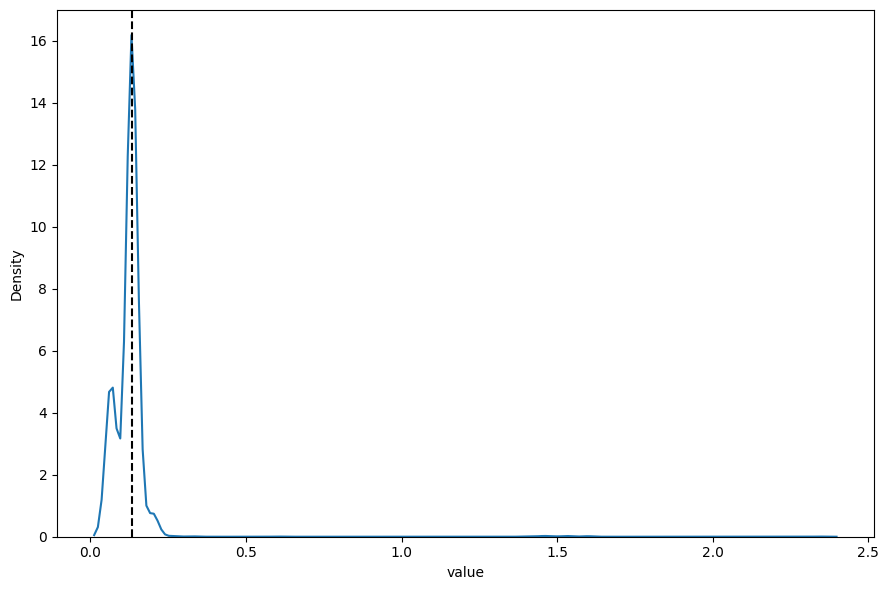

In [11]:
import seaborn as sns

sns.kdeplot(df['value']);
plt.grid(False)
plt.axvline(0.134, 0, 1, c='black', ls='--')
plt.tight_layout()

From the figure above, we can already see two problems. First, the data is close to a normal distribution. Second, the black dashed line indicates the median of the sample, and it fall right on the peak of the distribution. This means that a lot of data points are equal to the median, meaning that we are in a situation where the MAD is potentially 0 or very close to 0.

Nevertheless, let’s continue applying the method, just so that we understand how to work with it.

The next step, is to compute the MAD and the median of the sample to calculate the robust Z-score. The scipy package comes with an implementation of the MAD formula.

In [12]:
from scipy.stats import median_abs_deviation

mad = median_abs_deviation(df['value'])
median = np.median(df['value'])

print(median)
print(mad)

def compute_robust_z_score(x):
    return .6745*(x-median)/mad

0.134
0.0020000000000000018


In [13]:
df['z-score'] = df['value'].apply(compute_robust_z_score)

In [14]:
df.head()

,timestamp,value,is_anomaly,z-score
0,2014-02-14 14:30:00,0.132,1,-0.6745
1,2014-02-14 14:35:00,0.134,1,0.0000
2,2014-02-14 14:40:00,0.134,1,0.0000
3,2014-02-14 14:45:00,0.134,1,0.0000
4,2014-02-14 14:50:00,0.134,1,0.0000


We get a MAD of 0.002, which definitely close to 0, meaning that this baseline is likely not going to perform very well.

Once this is done, we decide on a threshold to flag outliers. A typical threshold is 3 or 3.5. In this case, any value with a robust Z-score greater than 3.5 (right-hand tail) or smaller than -3.5 (left-hand tail) will be flagged as an outlier.

In [15]:
df['baseline'] = 1
df.loc[df['z-score'] >= 3.5, 'baseline'] = -1
df.loc[df['z-score'] <=-3.5, 'baseline'] = -1

In [16]:
df.head()

,timestamp,value,is_anomaly,z-score,baseline
0,2014-02-14 14:30:00,0.132,1,-0.6745,1
1,2014-02-14 14:35:00,0.134,1,0.0000,1
2,2014-02-14 14:40:00,0.134,1,0.0000,1
3,2014-02-14 14:45:00,0.134,1,0.0000,1
4,2014-02-14 14:50:00,0.134,1,0.0000,1


Finally, we can plot a confusion matrix to see if our baseline correctly identified outliers and inliers.

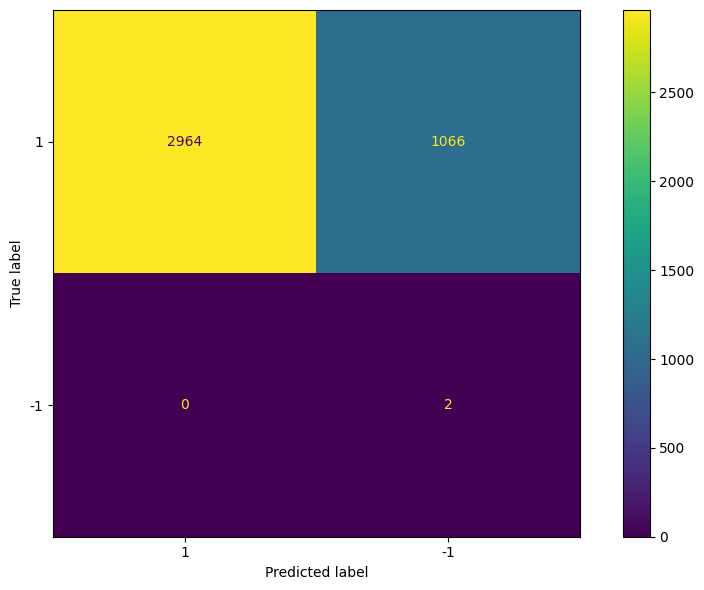

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(df['is_anomaly'], df['baseline'], labels=[1, -1])

disp_cm = ConfusionMatrixDisplay(cm, display_labels=[1, -1])

disp_cm.plot();

plt.grid(False)
plt.tight_layout()

Unsurprisingly, we see that the baseline method performs poorly, since 1066 inliers were flagged as outliers. Again, this was expected since our data did not respect the assumptions of the method, and the MAD was very close to 0. Still, I wanted to cover the implementation of this method in case it serves you in another scenario.

Although the results are disappointing, this method still holds when the assumptions are true for your dataset, and you now know how to apply it when it makes sense.

Now, let’s move on to the machine learning approached, starting with isolation forest.

### Isolation forest
The isolation forest algorithm is a tree-based algorithm that is often used for anomaly detection.

*The algorithm starts by randomly selecting an attribute and randomly selecting a split value between the maximum and minimum values for that attribute.* This partitioning is done many times until the algorithm has isolated each point in the dataset.

Then, the intuition behind this algorithm is that an outlier will take fewer partitions to be isolated than a normal point, as shown in the figures below.

In [18]:
from sklearn.ensemble import IsolationForest

First, let’s split our data into a training and a test set. That way, we can evaluate if the model is able to flag an anomaly on unseen data. This is sometimes called novelty detection, instead of anomaly detection.

In [19]:
train = df[:3550]
test = df[3550:]

Then, we can train our isolation forest algorithm. Here, we need to specify a level of contamination, which is simply the fraction of outliers in the training data. In this case, we only have one outlier in the training set.

In [21]:
# Only one outlier in the training set
contamination = 1/len(train)

iso_forest = IsolationForest(contamination=contamination, random_state=42)

X_train = train['value'].values.reshape(-1,1)

iso_forest.fit(X_train)

IsolationForest(contamination=0.00028169014084507044, random_state=42)

Once trained, we can then generate predictions.

In [22]:
preds_iso_forest = iso_forest.predict(test['value'].values.reshape(-1,1))

Again, we can plot the confusion matrix to see how the model performs.

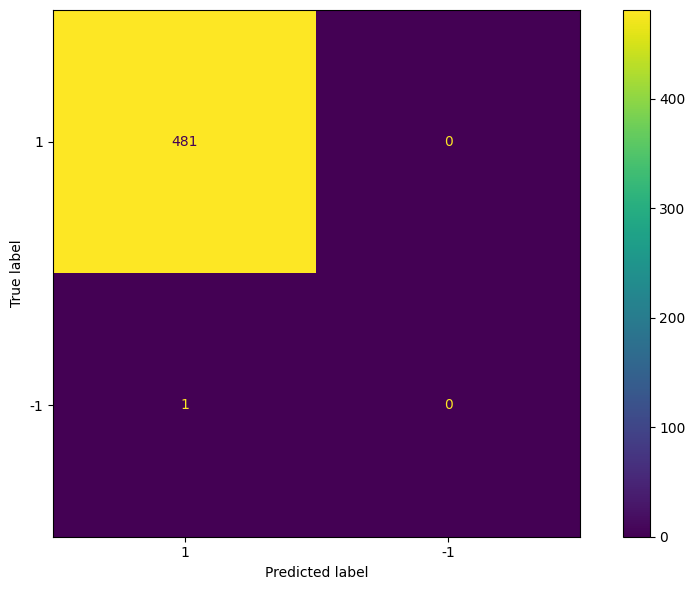

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test['is_anomaly'], preds_iso_forest, labels=[1, -1])

disp_cm = ConfusionMatrixDisplay(cm, display_labels=[1, -1])

disp_cm.plot();

plt.grid(False)
plt.tight_layout()

From the figure above, we notice that the algorithm was not able to flag the new anomaly. It also labelled an anomaly as a normal point.

Again, this is a disappointing result, but we still have one more method to cover, which is the local outlier factor.

### Local outlier factor (LOF)

Intuitively, the local outlier factor (LOF) works by comparing the local density of a point to the local densities of its neighbours. If the densities of the point and its neighbours are similar, then the point is an inlier.

However, if the density of the point is much smaller than the densities of its neighbours, then it must be an outlier, because a lower density means that the point is more isolated.


**Applying the local outlier factor method**
With the use of scikit-lean applying the local outlier factor method is straightforward. We use the same train/test split as for the isolation forest to have comparable results.

In [24]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(contamination=contamination, novelty=True)

lof.fit(X_train)

LocalOutlierFactor(contamination=0.00028169014084507044, novelty=True)

Then, we can generate the predictions to flag potential outliers in the test set.

In [25]:
preds_lof = lof.predict(test['value'].values.reshape(-1,1))

Finally, we plot the confusion matrix to evaluate the performance.

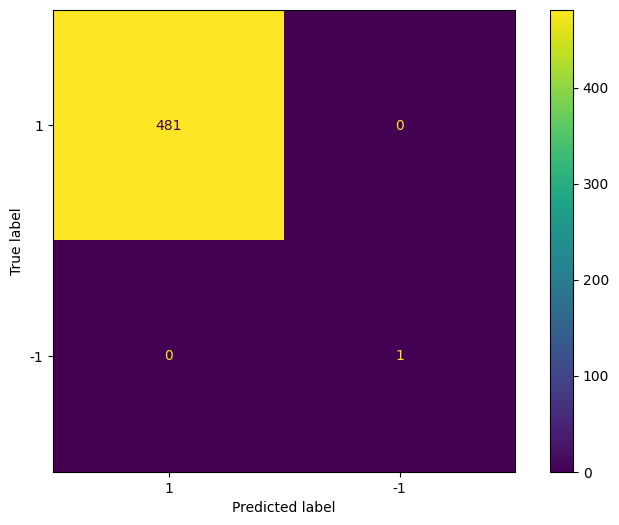

In [26]:
cm = confusion_matrix(test['is_anomaly'], preds_lof, labels=[1, -1])

disp_cm = ConfusionMatrixDisplay(cm, display_labels=[1, -1])

disp_cm.plot();

In the figure above we see that the LOF method was able to flag the only outlier in the test set, and correctly labelled every other point as a normal point.

As always, this does not mean that local outlier factor is better method than isolation forest. It simply means that it worked better in this particular situation.